In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [2]:
class CSIDataProcessor:
    def __init__(self, filename, kernel_size):
        self.filename = filename
        self.amplitudes = []
        self.kernel_size = kernel_size

    def process_csi_data(self):
        for line in open(self.filename, 'r'):
            if len(line) < 2:
                continue

            csi_values = re.findall(r'\[(.*?)\]', line)
            if len(csi_values) > 0:
                values = csi_values[0].split(',')
                amplitude_values = [int(val) for val in values if val.replace('-', '').isdigit()]
                amplitude = [np.sqrt(amplitude_values[i] ** 2 + amplitude_values[i + 1] ** 2)
                             for i in range(0, len(amplitude_values), 2)]
                # Apply noise removal and smoothing
                amplitude = signal.medfilt(amplitude, kernel_size=self.kernel_size)  # Median filtering
                self.amplitudes.append(amplitude)

    def plot_csi_amplitudes(self):
        self.process_csi_data()
        amplitudes = np.array(self.amplitudes)

        plt.figure(figsize=(8, 6))
        plt.pcolor(amplitudes.T, cmap='coolwarm')
        plt.colorbar()
        plt.title('CSI Amplitude Signal')
        plt.xlabel('Time')
        plt.ylabel('Subcarriers/Antennas')
        plt.show()

# Falling

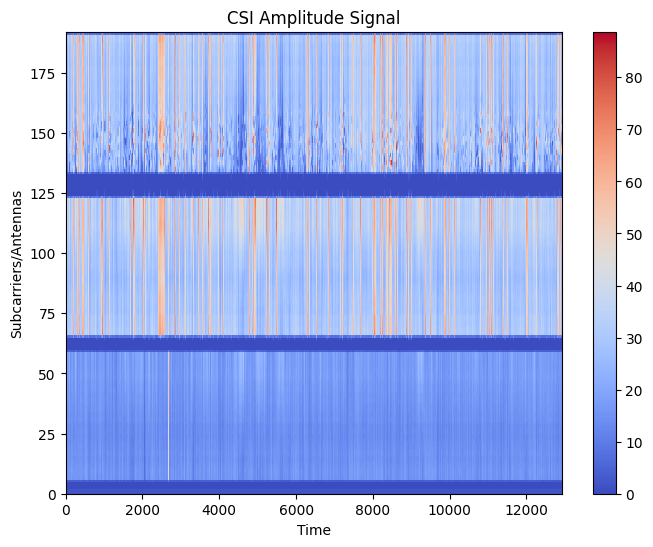

In [3]:
falling = CSIDataProcessor('DataRemoveNoise/falling.dat', kernel_size=3)
falling.plot_csi_amplitudes()

# Absence

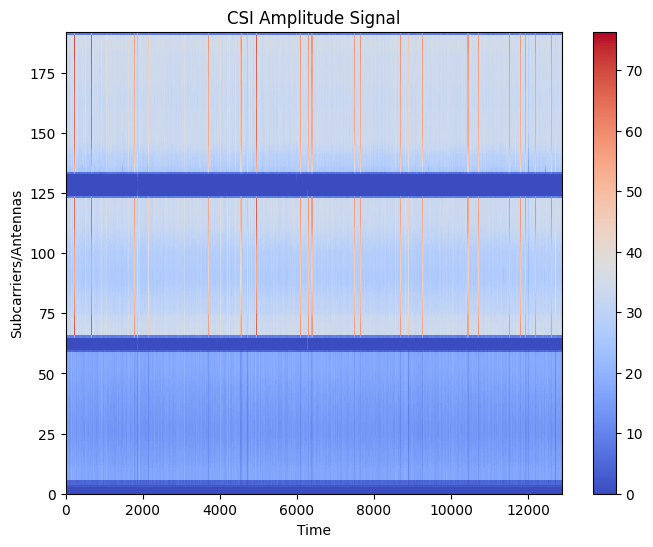

In [4]:
absence = CSIDataProcessor('DataRemoveNoise/absence.dat', kernel_size=9)
absence.plot_csi_amplitudes()

# Sleeping

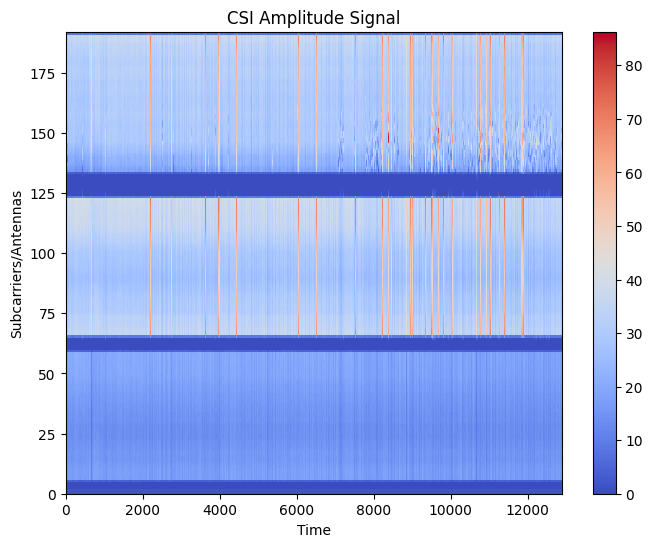

In [5]:
sleeping = CSIDataProcessor('DataRemoveNoise/sleeping.dat', kernel_size=3)
sleeping.plot_csi_amplitudes()

# Jumping

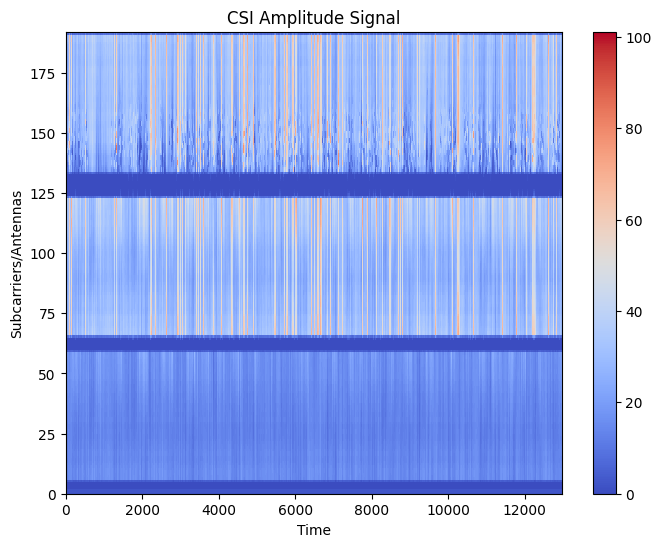

In [6]:
jumping = CSIDataProcessor('DataRemoveNoise/jumping.dat', kernel_size=3)
jumping.plot_csi_amplitudes()

# Standing

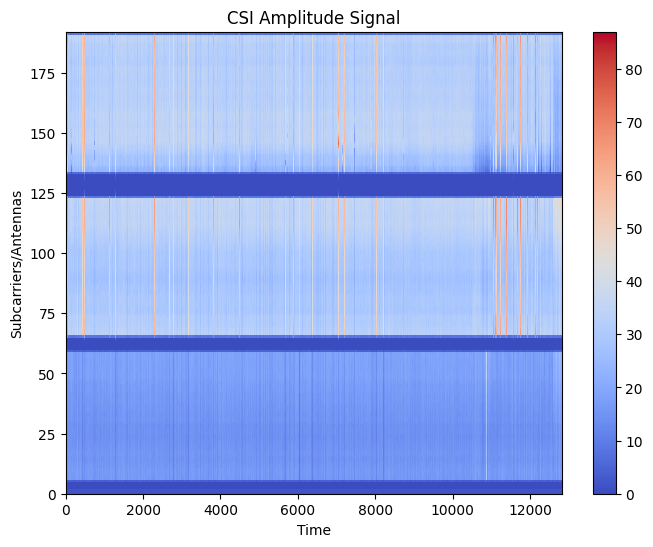

In [7]:
standing = CSIDataProcessor('DataRemoveNoise/standing.dat', kernel_size=3)
standing.plot_csi_amplitudes()

# Walking

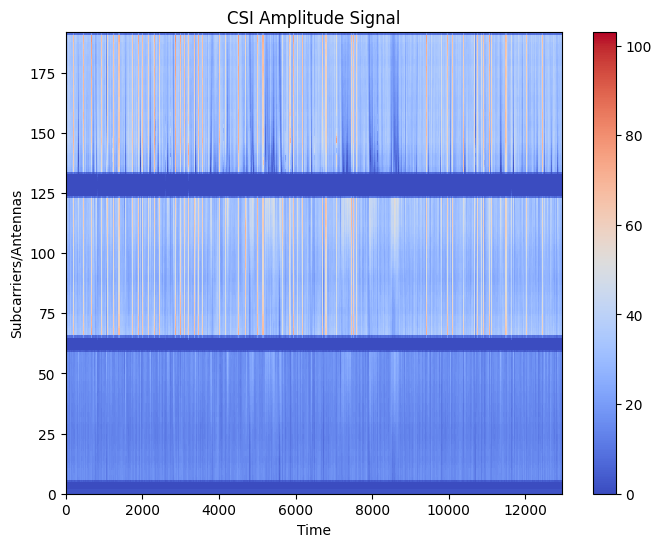

In [8]:
walking = CSIDataProcessor('DataRemoveNoise/walking.dat', kernel_size=3)
walking.plot_csi_amplitudes()

# Combine the data

In [9]:
data = []

for row in absence.amplitudes:
    flat_amplitudes = row.flatten()

    row_data = {'label': 'absence', 'amplitudes': flat_amplitudes}
    data.append(row_data)

for row in falling.amplitudes:
    flat_amplitudes = row.flatten()

    row_data = {'label': 'falling', 'amplitudes': flat_amplitudes}
    data.append(row_data)

for row in sleeping.amplitudes:
    flat_amplitudes = row.flatten()

    row_data = {'label': 'sleeping', 'amplitudes': flat_amplitudes}
    data.append(row_data)

for row in standing.amplitudes:
    flat_amplitudes = row.flatten()

    row_data = {'label': 'standing', 'amplitudes': flat_amplitudes}
    data.append(row_data)

for row in walking.amplitudes:
    flat_amplitudes = row.flatten()

    row_data = {'label': 'walking', 'amplitudes': flat_amplitudes}
    data.append(row_data)

for row in jumping.amplitudes:
    flat_amplitudes = row.flatten()

    row_data = {'label': 'jumping', 'amplitudes': flat_amplitudes}
    data.append(row_data)


df = pd.DataFrame(data)
df

,label,amplitudes
0,absence,"[0.0, 0.0, 0.0, 2.0, 5.0, 5.0, 18.027756377319..."
1,absence,"[0.0, 0.0, 0.0, 2.0, 4.47213595499958, 4.47213..."
2,absence,"[0.0, 0.0, 0.0, 2.0, 5.385164807134504, 5.3851..."
3,absence,"[0.0, 0.0, 0.0, 2.0, 4.47213595499958, 4.47213..."
4,absence,"[0.0, 0.0, 0.0, 2.0, 5.385164807134504, 5.3851..."
...,...,...
77403,jumping,"[2.0, 2.0, 0.0, 0.0, 0.0, 4.123105625617661, 1..."
77404,jumping,"[2.0, 2.0, 0.0, 0.0, 0.0, 3.605551275463989, 1..."
77405,jumping,"[2.0, 2.0, 0.0, 0.0, 0.0, 4.242640687119285, 1..."
77406,jumping,"[2.0, 2.0, 0.0, 0.0, 0.0, 3.1622776601683795, ..."


# Training 

In [10]:
X = pd.DataFrame(df['amplitudes'].tolist())
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (61926, 192)
X_test shape: (15482, 192)
y_train shape: (61926,)
y_test shape: (15482,)


## Dimensionality Reduction

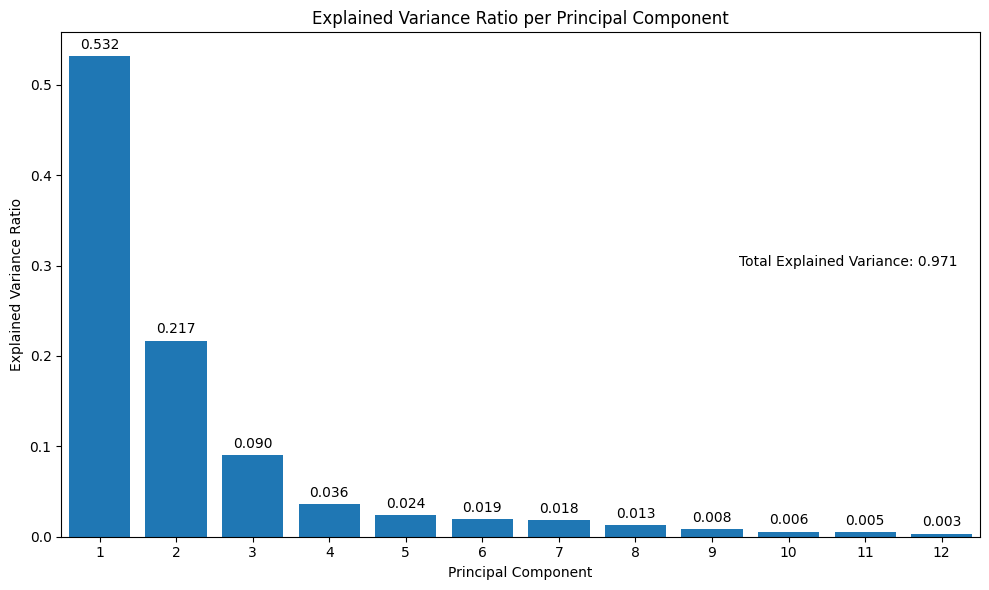

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=12)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

columns_pca = [f'PC{i+1}' for i in range(12)]
X_train_pca_df = pd.DataFrame(data=X_train_pca, columns=columns_pca)
X_test_pca_df = pd.DataFrame(data=X_test_pca, columns=columns_pca)

sorted_variance_ratio = sorted(pca.explained_variance_ratio_, reverse=True)
plt.figure(figsize=(10, 6))

plt.bar(range(1, len(sorted_variance_ratio) + 1), sorted_variance_ratio)

plt.xlim(0.5, len(sorted_variance_ratio) + 0.5)
plt.xticks(range(1, len(sorted_variance_ratio) + 1))

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Principal Component')

for i, ratio in enumerate(sorted_variance_ratio):
    plt.text(i + 1, ratio + 0.005, f'{ratio:.3f}', ha='center', va='bottom')

total_variance_ratio = sum(sorted_variance_ratio)

text_box = f'Total Explained Variance: {total_variance_ratio:.3f}'
plt.text(len(sorted_variance_ratio) + 0.2, 0.30, text_box, ha='right')

plt.tight_layout()
plt.show()

## Model_1 : Decision Tree

In [12]:
model_1 = tree.DecisionTreeClassifier()
model_1.fit(X_train_pca_df, y_train)

pred = model_1.predict(X_test_pca_df)
print(accuracy_score(y_test, pred))

0.7735434698359385


## Model_2 : Random Forest

In [13]:

# rf_classifier = RandomForestClassifier(random_state=102)

# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# grid_search.fit(X_train_pca_df, y_train)

# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}

In [14]:
best_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}

model_2 = RandomForestClassifier(**best_params, random_state=42)

model_2.fit(X_train_pca_df, y_train)

y_pred = model_2.predict(X_test_pca_df)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8446583128794729


## Model_3 : SVM Classifier

In [15]:
# svm = SVC()

# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['poly', 'rbf', 'sigmoid'],
#     'gamma': ['scale', 'auto'] 
# }

# grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

In [17]:
best_params = {'C': 150, 'kernel': 'rbf', 'gamma': 'scale'}

model_3 = SVC(**best_params)
model_3.fit(X_train_pca_df, y_train)

y_pred = model_3.predict(X_test_pca_df)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.84595013564139
